<a href="https://colab.research.google.com/github/jing-pw/YCBS258-Assignments/blob/master/C9_Exercise_Final_JW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Times Series Forecasting Exercise
1. Choose a dataset
2. Visualize the dataset
3. Split data - Use the last 20% of values as test
4. Use 4 model architectures that we demonstrated in class
5. Explain which strategy was the best and why you think it was the best

In [2]:
!wget https://storage.googleapis.com/nicksdemobucket/temps.csv

--2019-07-14 22:13:46--  https://storage.googleapis.com/nicksdemobucket/temps.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [application/octet-stream]
Saving to: ‘temps.csv.2’

temps.csv.2         100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2019-07-14 22:13:46 (87.9 MB/s) - ‘temps.csv.2’ saved [67921/67921]



I chose the daily tempature data for the practice, thought it'd be interesting to actually be able to forecast the weather.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv('temps.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [5]:
df.shape

(3650, 2)

In [0]:
ts = df['Temp'].values.astype(np.float32)

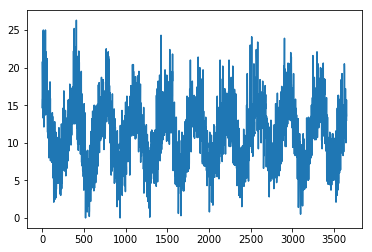

In [7]:
#visualize the dataset

plt.plot(ts);

We see some patterns in data, and it's time related. So time series analysis models can be applied.

In [8]:
print(ts.shape)

(3650,)


In [0]:
#prepare the data for time series models
#normalize the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(ts.reshape(-1,1))

In [10]:
data.shape

(3650, 1)

In [0]:
#split data - Use the last 20% of values as test set to evaluate the model perf
train_size = int(len(data) * 0.8)
train, test = data[:train_size,:], data[train_size:,:]

In [12]:
print(train.shape)
print(test.shape)

(2920, 1)
(730, 1)


In [13]:
#again split the training data to train set and validation set
#use 90% for training and 10% for validation
split = int(len(train)*0.9)
train, valid = train[:split,:], train[split:,:]
print(train.shape)
print(valid.shape)

(2628, 1)
(292, 1)


In [0]:
#create timeseries data matrix to be used by supervised learning
#the function returns the input and output series to be fed to model
#length is the number of time steps to be used for prediction
#step is the number of time steps to predict
#by default length=1 and step=1, means using t-1 to predict t

def generate_series(data, length=1, step=1):
	X, y = [], []
	for i in range(len(data)-length):
		a = data[i:(i+length), 0]
		X.append(a)
		y.append(data[(i+length):(i+length+step), 0])
	return np.array(X), np.array(y)

trainX, trainY = generate_series(train)
validX, validY = generate_series(valid)
testX, testY = generate_series(test)

In [17]:
#reshape data to the format required by RNN models
#(samples, timestep, features)
#since the dataset is univariant, features=1

trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
validX = validX.reshape(validX.shape[0], 1, validX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(2627, 1, 1)
(2627, 1)
(291, 1, 1)
(291, 1)
(729, 1, 1)
(729, 1)


In [18]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Conv1D, TimeDistributed
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [0]:
#build a SimpleRNN model
K.clear_session()

model_rnn = Sequential()
model_rnn.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model_rnn.add(SimpleRNN(20))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mse', optimizer='adam')

In [22]:
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_rnn.fit(trainX, trainY, 
              validation_data=(validX, validY),
              epochs=100, verbose=2, callbacks=[early_stop])

Train on 2627 samples, validate on 291 samples
Epoch 1/100
 - 2s - loss: 0.0289 - val_loss: 0.0103
Epoch 2/100
 - 0s - loss: 0.0104 - val_loss: 0.0101
Epoch 3/100
 - 0s - loss: 0.0100 - val_loss: 0.0103
Epoch 4/100
 - 0s - loss: 0.0100 - val_loss: 0.0105
Epoch 5/100
 - 0s - loss: 0.0100 - val_loss: 0.0104
Epoch 6/100
 - 0s - loss: 0.0100 - val_loss: 0.0103
Epoch 7/100
 - 0s - loss: 0.0100 - val_loss: 0.0104
Epoch 00007: early stopping


In [24]:
#evaluate the model
model_rnn.evaluate(testX, testY)

729/729 [==============================] - 0s 58us/step


0.008148684977606164

In [0]:
#save the model for later compare
model_rnn.save("model_rnn.h5")

In [26]:
#implement a custom metrics to evaluate model on all prediction step errors
#in order to use TimeDistributed layer, outputs have to be reshaped too

def last_time_step_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

trainYt = trainY.reshape(trainY.shape[0], trainY.shape[1], 1)
validYt = validY.reshape(validY.shape[0], validY.shape[1], 1)
testYt = testY.reshape(testY.shape[0], testY.shape[1], 1)

print(trainYt.shape)
print(validYt.shape)
print(testYt.shape)

(2627, 1, 1)
(291, 1, 1)
(729, 1, 1)


In [0]:
#build a seq2seq model
#utilize TimeDistributed layter to wrap any layers to apply to every time step

K.clear_session()

model_seq2seq = Sequential()
model_seq2seq.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model_seq2seq.add(SimpleRNN(20, return_sequences=True))
model_seq2seq.add(TimeDistributed(Dense(1)))
model_seq2seq.compile(loss='mse', optimizer='adam', 
                      metrics=[last_time_step_mse])

In [28]:
model_seq2seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_seq2seq.fit(trainX, trainYt, 
                  validation_data=(validX, validYt),
                  epochs=100, verbose=2,
                  callbacks=[early_stop])

Train on 2627 samples, validate on 291 samples
Epoch 1/100
 - 1s - loss: 0.0113 - last_time_step_mse: 0.0113 - val_loss: 0.0104 - val_last_time_step_mse: 0.0104
Epoch 2/100
 - 0s - loss: 0.0100 - last_time_step_mse: 0.0100 - val_loss: 0.0105 - val_last_time_step_mse: 0.0105
Epoch 3/100
 - 0s - loss: 0.0099 - last_time_step_mse: 0.0099 - val_loss: 0.0105 - val_last_time_step_mse: 0.0105
Epoch 4/100
 - 0s - loss: 0.0100 - last_time_step_mse: 0.0100 - val_loss: 0.0104 - val_last_time_step_mse: 0.0104
Epoch 5/100
 - 0s - loss: 0.0100 - last_time_step_mse: 0.0100 - val_loss: 0.0104 - val_last_time_step_mse: 0.0104
Epoch 6/100
 - 0s - loss: 0.0101 - last_time_step_mse: 0.0101 - val_loss: 0.0107 - val_last_time_step_mse: 0.0107
Epoch 00006: early stopping


In [30]:
model_seq2seq.evaluate(testX, testYt)

729/729 [==============================] - 0s 67us/step


[0.008255479891818983, 0.008255479891818983]

In [0]:
model_seq2seq.save("model_seq2seq.h5")

In [0]:
#build a LSTM model
K.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(20, return_sequences=True, input_shape=(None, 1)))
model_lstm.add(LSTM(20))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')

In [38]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_lstm.fit(trainX,trainY, 
               validation_data=(validX, validY),
               epochs=100, verbose=2, callbacks=[early_stop])

Train on 2627 samples, validate on 291 samples
Epoch 1/100
 - 2s - loss: 0.1004 - val_loss: 0.0148
Epoch 2/100
 - 1s - loss: 0.0154 - val_loss: 0.0120
Epoch 3/100
 - 1s - loss: 0.0138 - val_loss: 0.0111
Epoch 4/100
 - 1s - loss: 0.0122 - val_loss: 0.0104
Epoch 5/100
 - 1s - loss: 0.0111 - val_loss: 0.0101
Epoch 6/100
 - 1s - loss: 0.0105 - val_loss: 0.0102
Epoch 7/100
 - 1s - loss: 0.0101 - val_loss: 0.0101
Epoch 8/100
 - 1s - loss: 0.0101 - val_loss: 0.0102
Epoch 9/100
 - 1s - loss: 0.0101 - val_loss: 0.0103
Epoch 10/100
 - 1s - loss: 0.0101 - val_loss: 0.0102
Epoch 00010: early stopping


In [40]:
model_lstm.evaluate(testX, testY)

729/729 [==============================] - 0s 69us/step


0.008220734540373087

In [0]:
model_lstm.save("model_lstm.h5")

In [0]:
#build a GRU model
K.clear_session()

model_gru = Sequential()
model_gru.add(GRU(20, return_sequences=True, input_shape=[None, 1]))
model_gru.add(GRU(20, return_sequences=True))
model_gru.add(TimeDistributed(Dense(1)))
model_gru.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

In [43]:
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 20)          1320      
_________________________________________________________________
gru_2 (GRU)                  (None, None, 20)          2460      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           21        
Total params: 3,801
Trainable params: 3,801
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_gru.fit(trainX, trainYt,
             validation_data=(validX, validYt),
             epochs=100, verbose=2, callbacks=[early_stop])

Train on 2627 samples, validate on 291 samples
Epoch 1/100
 - 1s - loss: 0.0766 - last_time_step_mse: 0.0766 - val_loss: 0.0124 - val_last_time_step_mse: 0.0124
Epoch 2/100
 - 1s - loss: 0.0139 - last_time_step_mse: 0.0139 - val_loss: 0.0112 - val_last_time_step_mse: 0.0112
Epoch 3/100
 - 1s - loss: 0.0123 - last_time_step_mse: 0.0123 - val_loss: 0.0105 - val_last_time_step_mse: 0.0105
Epoch 4/100
 - 1s - loss: 0.0111 - last_time_step_mse: 0.0111 - val_loss: 0.0102 - val_last_time_step_mse: 0.0102
Epoch 5/100
 - 1s - loss: 0.0103 - last_time_step_mse: 0.0103 - val_loss: 0.0101 - val_last_time_step_mse: 0.0101
Epoch 6/100
 - 1s - loss: 0.0101 - last_time_step_mse: 0.0101 - val_loss: 0.0102 - val_last_time_step_mse: 0.0102
Epoch 7/100
 - 1s - loss: 0.0100 - last_time_step_mse: 0.0100 - val_loss: 0.0103 - val_last_time_step_mse: 0.0103
Epoch 8/100
 - 1s - loss: 0.0100 - last_time_step_mse: 0.0100 - val_loss: 0.0103 - val_last_time_step_mse: 0.0103
Epoch 9/100
 - 1s - loss: 0.0100 - last_t

In [45]:
model_gru.evaluate(testX, testYt)

729/729 [==============================] - 0s 85us/step


[0.00878338387302431, 0.00878338387302431]

In [0]:
model_gru.save("model_gru.h5")

In [0]:
#build a wavenet

from keras.layers import InputLayer, Conv1D

model_wavenet = Sequential()
model_wavenet.add(InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model_wavenet.add(Conv1D(filters=20, kernel_size=2, padding="causal",
                             activation="relu", dilation_rate=rate))
model_wavenet.add(Conv1D(filters=1, kernel_size=1))
model_wavenet.compile(loss="mse", optimizer="adam", 
                      metrics=[last_time_step_mse])

In [48]:
model_wavenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 20)          60        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 20)          820       
__________

In [49]:
model_wavenet.fit(trainX, trainYt, 
                  epochs=100, verbose=2,
                  validation_data=(validX, validYt),
                  callbacks=[early_stop])

Train on 2627 samples, validate on 291 samples
Epoch 1/100
 - 3s - loss: 0.0903 - last_time_step_mse: 0.0903 - val_loss: 0.0140 - val_last_time_step_mse: 0.0140
Epoch 2/100
 - 1s - loss: 0.0160 - last_time_step_mse: 0.0160 - val_loss: 0.0112 - val_last_time_step_mse: 0.0112
Epoch 3/100
 - 1s - loss: 0.0114 - last_time_step_mse: 0.0114 - val_loss: 0.0102 - val_last_time_step_mse: 0.0102
Epoch 4/100
 - 1s - loss: 0.0101 - last_time_step_mse: 0.0101 - val_loss: 0.0105 - val_last_time_step_mse: 0.0105
Epoch 5/100
 - 1s - loss: 0.0102 - last_time_step_mse: 0.0102 - val_loss: 0.0103 - val_last_time_step_mse: 0.0103
Epoch 6/100
 - 1s - loss: 0.0102 - last_time_step_mse: 0.0102 - val_loss: 0.0104 - val_last_time_step_mse: 0.0104
Epoch 7/100
 - 1s - loss: 0.0101 - last_time_step_mse: 0.0101 - val_loss: 0.0102 - val_last_time_step_mse: 0.0102
Epoch 8/100
 - 1s - loss: 0.0103 - last_time_step_mse: 0.0103 - val_loss: 0.0104 - val_last_time_step_mse: 0.0104
Epoch 00008: early stopping


In [50]:
model_wavenet.evaluate(testX, testYt)

729/729 [==============================] - 0s 81us/step


[0.008146537681824346, 0.008146537681824346]

In [0]:
model_wavenet.save("model_wavenet.h5")

Now put model evaluations together

*   SimpleRNN: 0.008149
*   Seq2Seq: 0.008255
*   LSTM: 0.008221
*   GRU: 0.008783
*   Wavenet: 0.008147

Wavenet seems give slightly better result but all models yield very close results. However, my practice is only to use t-1 to predict t, it may show differences when the task is more completed i.e. use more time steps to predict multiple steps ahead.
Both LSTM and GRU are known to be good remedies of vanishing gradient while handling long term dependencies. Add Wavenet is known for its efficency and good performance. It's commonly used for music generations

In [0]:
#use wavenet model to predict test data
testYh = model_wavenet.predict(testX)

In [53]:
print(testYh.shape)

(729, 1, 1)


In [0]:
testPred = testYh.reshape(testYh.shape[0],1)

In [0]:
testPred = scaler.inverse_transform(testPred)

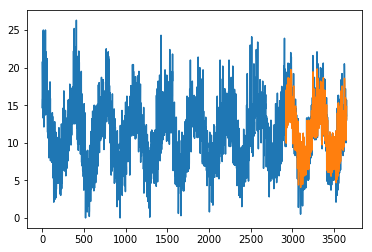

In [56]:
#plot predicted test set

testPlot = np.empty_like(data)
testPlot[:,:] = np.nan
testPlot[-len(testPred):,:] = testPred
plt.plot(scaler.inverse_transform(data))
plt.plot(testPlot);

The prediction looks very close to ground truth.